# A continuous controller acting on a sampled TCLab
This notebook shows a correct implementation of a continuous controller acting on a sampled TCLab system.

The diagram for this system looks approximately like this:

![](../assets/continuous_controller.png)



$G_C$ is a continuous system. TCLab is also continuous (the temperature exists continuously), but we _interact_ with it via a sampled channel, so the output from the controller is sampled and held during the write. For simplicity we model the idea that the temperature is also sampled by sampling the error.

In [1]:
# !pip install control==0.8.3

In [2]:
import tclab
import control
import numpy

In [3]:
from tqdm.auto import tqdm

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

We will control $T_1$ to this setpoint

In [5]:
def setpoint(t):
    if t < 300:
        return 20
    else:
        return 50

We will have a disturbance in $Q_2$ to reject

In [6]:
def disturbance(t):
    if t < 800:
        return 20
    else:
        return 30

## Construct controller object

This is a realisable PID controller

In [7]:
s = control.TransferFunction([1,0],1)

In [8]:
controllertype = 'PID'

In [9]:
## IAE PID

Kc = 11.01
tau_i = 207.34
tau_d = 7.29
alpha = 0.1

def setpoint(t):
    if t < 300:
        return 20
    else:
        return 50
    
def disturbance(t):
    if t < 800:
        return 20
    else:
        return 20
    
steptime = 1
totaltime = 1200

In [10]:
# ## IAE PI

# Kc = 7.56
# tau_i = 152.97
# tau_d = 0
# alpha = 0.1

# def setpoint(t):
#     if t < 20:
#         return 20
#     else:
#         return 35
    
# def disturbance(t):
#     if t < 800:
#         return 20
#     else:
#         return 20
    
# steptime = 1
# totaltime = 500

In [11]:
# ## COHEN COON PID 

# Kc = 18.55
# tau_i = 41.49
# tau_d = 6.3
# alpha = 0.1

# def setpoint(t):
#     if t < 300:
#         return 20
#     else:
#         return 50
    
# def disturbance(t):
#     if t < 800:
#         return 20
#     else:
#         return 20
    
# steptime = 1
# totaltime = 1200

In [12]:
# ## COHEN COON PI

# Kc = 12.24
# tau_i = 46.58
# tau_d = 0

# def setpoint(t):
#     if t < 20:
#         return 20
#     else:
#         return 35
    
# def disturbance(t):
#     if t < 800:
#         return 20
#     else:
#         return 20
    
# steptime = 1
# totaltime = 500

In [13]:
bias = 57.79

In [14]:
if 'I' in controllertype:
    Gc = Kc*(1 + 1/(tau_i*s) + tau_d*s/(alpha*tau_d*s + 1))
else:
    Gc = Kc*(1 + tau_d*s/(alpha*tau_d*s + 1))    

In [15]:
# simulate zero-error run to get initial state vector
T, yout, xout = control.forced_response(Gc, [0, 1], None, transpose=True)

# get initial state vector
xc = xout[-1]

In [16]:
# steptime = 1
# totaltime = 1300

In [17]:
times = numpy.arange(0, totaltime, steptime)

with tclab.TCLabModel(synced=False) as lab:  # change to TCLab for real
    historian = tclab.Historian(lab.sources)
    
    prev_t = 0
    
    error = setpoint(0) - lab.T1

    for t in tqdm(times):  # change to tclab.clock(steptime=steptime) to sync with time
        # Figure out how much time has gone by since previous clock tick
        # Note in the simulation case this will always be `steptime`, but when we sync
        # it may not be, so we have to calculate correctly
        Δt = t - prev_t
        prev_t = t
        
        # integrate controller assuming error stays constant over timestep (zero-order-hold)
        # notice we're using the error from the previous time step, 
        # because we're simulating from one step ago to right now.
        _, yout, xout = control.forced_response(Gc, [0, Δt], [error, error], xc, transpose=True)
        
        controller_output = yout[-1] + bias
        xc = xout[-1]
        
        # communicate with tclab
        # We read the error at "the same time" as we write
        # This ensures that the controller uses only information from the previous time step
        error = setpoint(t) - lab.T1
                
        # write out to tclab
        lab.Q2(disturbance(t))
        lab.Q1(controller_output)
        
        # update historian
        historian.update(t)
        lab.update(t)  # for the real lab this is not required

TCLab version 0.4.9
Simulated TCLab



TCLab Model disconnected successfully.


In [18]:
historian.to_csv('run_IAE_PID.csv')

# Plotting

Note that I write the run data to a file, then analyse separately. This is a good pattern as it allows you to experiment with outputs without having to re-run your experiment

In [19]:
import pandas

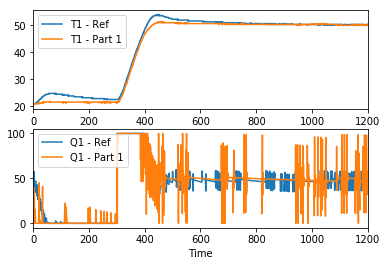

In [20]:
df = pandas.read_csv('run_IAE_PID.csv').set_index('Time')
us = pandas.read_csv('IAE_PID.csv').set_index('Time')

fig, (axtemp, axheat) = plt.subplots(2, 1)
df[['T1']].rename(columns={'T1': 'T1 - Ref'}).plot(ax=axtemp)
us[['T1']].rename(columns={'T1': 'T1 - Part 1'}).plot(ax=axtemp)
df[['Q1']].rename(columns={'Q1': 'Q1 - Ref'}).plot(ax=axheat)
us[['Q1']].rename(columns={'Q1': 'Q1 - Part 1'}).plot(ax=axheat)
plt.savefig('IAE_PID_Comparison.pdf', format='pdf')

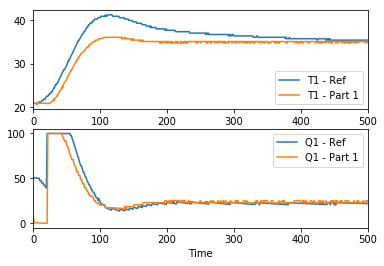

In [21]:
df = pandas.read_csv('run_IAE_PI.csv').set_index('Time')
us = pandas.read_csv('IAE_PI.csv').set_index('Time')

fig, (axtemp, axheat) = plt.subplots(2, 1)
df[['T1']].rename(columns={'T1': 'T1 - Ref'}).plot(ax=axtemp)
us[['T1']].rename(columns={'T1': 'T1 - Part 1'}).plot(ax=axtemp)
df[['Q1']].rename(columns={'Q1': 'Q1 - Ref'}).plot(ax=axheat)
us[['Q1']].rename(columns={'Q1': 'Q1 - Part 1'}).plot(ax=axheat)
plt.savefig('IAE_PI_Comparison.pdf', format='pdf')

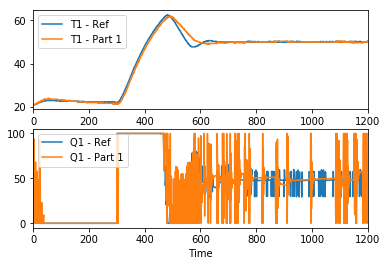

In [22]:
df = pandas.read_csv('run_CC_PID.csv').set_index('Time')
us = pandas.read_csv('CC_PID.csv').set_index('Time')

fig, (axtemp, axheat) = plt.subplots(2, 1)
df[['T1']].rename(columns={'T1': 'T1 - Ref'}).plot(ax=axtemp)
us[['T1']].rename(columns={'T1': 'T1 - Part 1'}).plot(ax=axtemp)
df[['Q1']].rename(columns={'Q1': 'Q1 - Ref'}).plot(ax=axheat)
us[['Q1']].rename(columns={'Q1': 'Q1 - Part 1'}).plot(ax=axheat)
plt.savefig('CC_PID_Comparison.pdf', format='pdf')

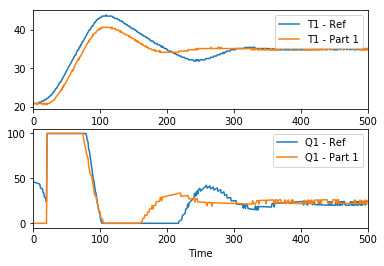

In [23]:
df = pandas.read_csv('run_CC_PI.csv').set_index('Time')
us = pandas.read_csv('CC_PI.csv').set_index('Time')

fig, (axtemp, axheat) = plt.subplots(2, 1)
df[['T1']].rename(columns={'T1': 'T1 - Ref'}).plot(ax=axtemp)
us[['T1']].rename(columns={'T1': 'T1 - Part 1'}).plot(ax=axtemp)
df[['Q1']].rename(columns={'Q1': 'Q1 - Ref'}).plot(ax=axheat)
us[['Q1']].rename(columns={'Q1': 'Q1 - Part 1'}).plot(ax=axheat)
plt.savefig('CC_PI_Comparison.pdf', format='pdf')